In [1]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant, safe_logodds
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-10 13:35:15.019945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 13:35:15.019971: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 9984
num_val=20000
noise_level=0.01
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [3]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0084),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/15


2022-05-10 13:35:17.856981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-10 13:35:17.857016: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-10 13:35:17.857047: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-10 13:35:17.857505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1248/1248 [==============================] - 4s 3ms/step - loss: 0.3866 - accuracy: 0.8179 - auc: 0.9070 - val_loss: 0.2752 - val_accuracy: 0.8874 - val_auc: 0.9564
Epoch 2/15
1248/1248 [==============================] - 3s 3ms/step - loss: 0.2494 - accuracy: 0.9041 - auc: 0.9631 - val_loss: 0.2009 - val_accuracy: 0.9245 - val_auc: 0.9758
Epoch 3/15
1248/1248 [==============================] - 3s 2ms/step - loss: 0.1926 - accuracy: 0.9279 - auc: 0.9774 - val_loss: 0.1651 - val_accuracy: 0.9358 - val_auc: 0.9834
Epoch 4/15
1248/1248 [==============================] - 3s 3ms/step - loss: 0.1617 - accuracy: 0.9393 - auc: 0.9838 - val_loss: 0.1548 - val_accuracy: 0.9401 - val_auc: 0.9856
Epoch 5/15
1248/1248 [==============================] - 3s 2ms/step - loss: 0.1433 - accuracy: 0.9498 - auc: 0.9865 - val_loss: 0.1384 - val_accuracy: 0.9501 - val_auc: 0.9880
Epoch 6/15
1248/1248 [==============================] - 3s 3ms/step - loss: 0.1324 - accuracy: 0.9528 - auc: 0.9880 - val_loss: 0.1

In [4]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

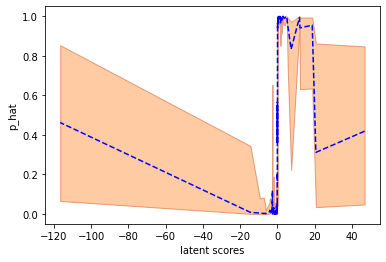

In [5]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

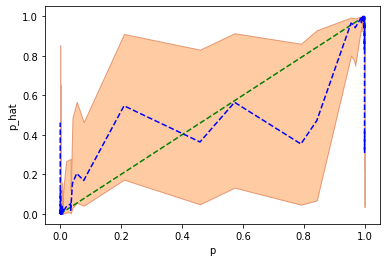

In [6]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [7]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 13:36:08.609168: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-05-10 13:37:22.923315: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.01: 73.74000000000001% within 90% CI


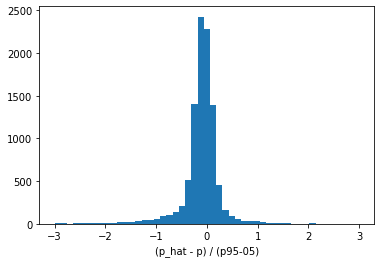

In [8]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.01: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

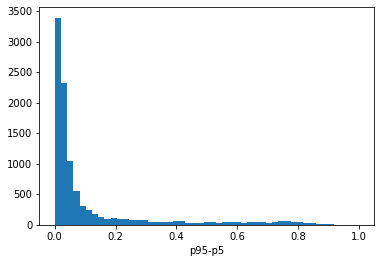

In [9]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [10]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 9984
num_val=20000
noise_level=0.1
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [11]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=14,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/14
1248/1248 [==============================] - 4s 3ms/step - loss: 0.5228 - accuracy: 0.7354 - auc: 0.8229 - val_loss: 0.4093 - val_accuracy: 0.8343 - val_auc: 0.9034
Epoch 2/14
1248/1248 [==============================] - 3s 2ms/step - loss: 0.3867 - accuracy: 0.8510 - auc: 0.9143 - val_loss: 0.3553 - val_accuracy: 0.8641 - val_auc: 0.9267
Epoch 3/14
1248/1248 [==============================] - 3s 2ms/step - loss: 0.3266 - accuracy: 0.8773 - auc: 0.9372 - val_loss: 0.3148 - val_accuracy: 0.8851 - val_auc: 0.9415
Epoch 4/14
1248/1248 [==============================] - 3s 2ms/step - loss: 0.2942 - accuracy: 0.8943 - auc: 0.9476 - val_loss: 0.2898 - val_accuracy: 0.8925 - val_auc: 0.9489
Epoch 5/14
1248/1248 [==============================] - 3s 2ms/step - loss: 0.2791 - accuracy: 0.8992 - auc: 0.9518 - val_loss: 0.2780 - val_accuracy: 0.8991 - val_auc: 0.9524
Epoch 6/14
1248/1248 [==============================] - 3s 2ms/step - loss: 0.2656 - accuracy: 0.9038 - auc: 0.9548 - va

In [12]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

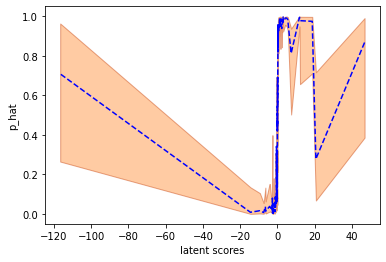

In [13]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

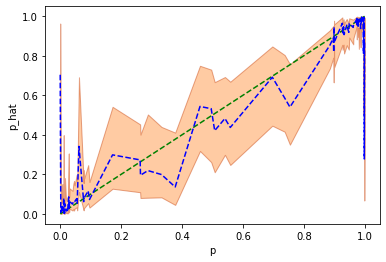

In [14]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [15]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 13:39:58.888477: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-05-10 13:41:05.465770: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.1: 86.18% within 90% CI


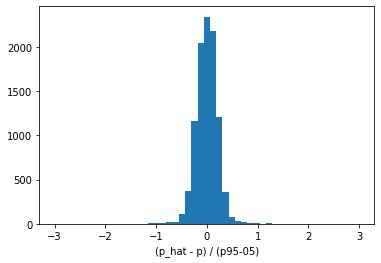

In [16]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.1: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

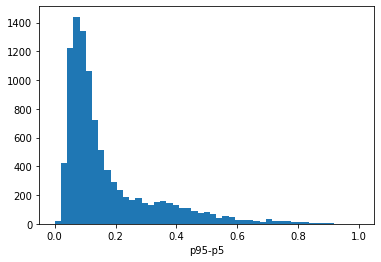

In [17]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [18]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 9984
num_val=20000
noise_level=0.3
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [19]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=16,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/16
1248/1248 [==============================] - 4s 3ms/step - loss: 0.5999 - accuracy: 0.6674 - auc: 0.7381 - val_loss: 0.5534 - val_accuracy: 0.7403 - val_auc: 0.8137
Epoch 2/16
1248/1248 [==============================] - 3s 2ms/step - loss: 0.5071 - accuracy: 0.7803 - auc: 0.8417 - val_loss: 0.4860 - val_accuracy: 0.7943 - val_auc: 0.8563
Epoch 3/16
1248/1248 [==============================] - 3s 2ms/step - loss: 0.4631 - accuracy: 0.8022 - auc: 0.8671 - val_loss: 0.4472 - val_accuracy: 0.8096 - val_auc: 0.8770
Epoch 4/16
1248/1248 [==============================] - 3s 2ms/step - loss: 0.4400 - accuracy: 0.8133 - auc: 0.8792 - val_loss: 0.4393 - val_accuracy: 0.8159 - val_auc: 0.8826
Epoch 5/16
1248/1248 [==============================] - 3s 2ms/step - loss: 0.4260 - accuracy: 0.8235 - auc: 0.8867 - val_loss: 0.4215 - val_accuracy: 0.8212 - val_auc: 0.8897
Epoch 6/16
1248/1248 [==============================] - 3s 2ms/step - loss: 0.4244 - accuracy: 0.8201 - auc: 0.8874 - va

In [20]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

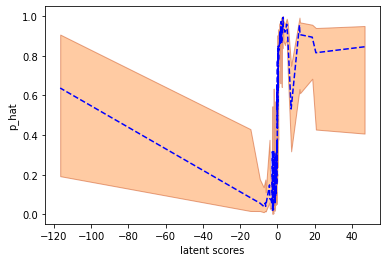

In [21]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

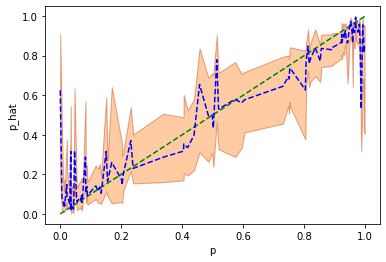

In [22]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [23]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 13:43:03.946862: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.3: 81.58% within 90% CI


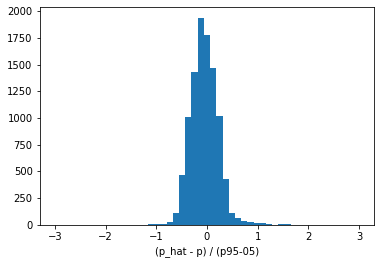

In [24]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.3: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

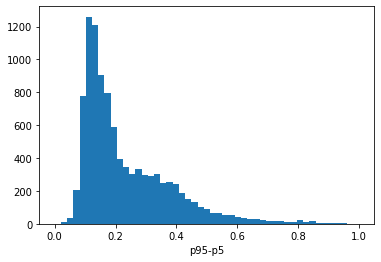

In [25]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()